<a href="https://colab.research.google.com/github/Shayshu-NR/ECE421/blob/main/Lab%201/ECE421_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shayshu Nahata-Ragubance<br>
1005035196

# Logistic Regression with Numpy


In [ ]:
# Import required libraries
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

TensorFlow 1.x selected.


In [ ]:
# Load data 
def loadData():
  with np.load('notMNIST.npz') as dataset:
    
      Data, Target = dataset['images'], dataset['labels']
      posClass = 2
      negClass = 9

      dataIndx = (Target==posClass) + (Target==negClass)
      Data = Data[dataIndx]/255.

      Target = Target[dataIndx].reshape(-1, 1)
      Target[Target==posClass] = 1
      Target[Target==negClass] = 0

      np.random.seed(421)
      randIndx = np.arange(len(Data))
      np.random.shuffle(randIndx)
      Data, Target = Data[randIndx], Target[randIndx]

      trainData, trainTarget = Data[:3500], Target[:3500]
      validData, validTarget = Data[3500:3600], Target[3500:3600]
      testData, testTarget = Data[3600:], Target[3600:]

  return trainData, validData, testData, trainTarget, validTarget, testTarget
    


In [ ]:
# Load the data from notMNIST.npz
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

## Loss function:
$L = L_{ce} + L_{w}$<br><br>

$L = \frac{1}{N} \sum_{n = 1}^{d} [-y_n log( \hat{y}(\vec{x_n}))\hspace{1mm} - \hspace{1mm} (1-y_n)log(1- \hat{y}(\vec{x_n}))] \hspace{1mm} + \hspace{1mm} \frac{\lambda}{2}||\vec{w}||_2^2$ <br><br>



In [ ]:
def loss(W, b, x, y, reg):
  # X is a data matrix of 3500 x 28 x 28
  # So flatten it such that the dimensions is now 3500 x 784
  X_processed = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2]))

  # ||w||^2_2  = wTw = sqrt(w_1^2 + w_2^2 ... w_d^2)^2
  regularization = (reg/2.0) * np.linalg.norm(W)**2

  # y_hat = O(wT * x + b) => O(X * w + b), where X is te data matrix
  y_hat = 1.0 / (1.0 + np.exp(-( (np.matmul(X_processed, W)) + b)))

  # Sum over all y with the given y_hat then divide by the number of rows of y
  # which is the same as the number of samples 
  sum = np.sum(np.multiply(y * -1, np.log(y_hat)) - np.multiply((1-y), np.log(1 - y_hat))) / (y.shape[0])

  loss = sum + regularization
  return loss

In [ ]:
# Testing loss
W = np.zeros(28*28)
print(trainData.reshape(3500, 784).shape, W.shape)
print(loss(W, 1, trainData, trainTarget, 3))

(3500, 784) (784,)
2839.415906313739


## Graident loss:
$\nabla L = \frac{1}{N} \sum_{n=1}^{N} -y_nx_n\theta (-y_nw^Tx_n) \hspace{1mm}+ \hspace{1mm} \lambda \vec{w} $<br><br>

$\nabla L = \frac{1}{N}\boldsymbol{X}^Tp \hspace{2mm} + \lambda \vec{w}\hspace{2mm}, where \hspace{2mm} p = \begin{bmatrix} 
\theta(\vec{w^T}\vec{x_1} + \hspace{1mm}b) \hspace{1mm}-\hspace{1mm}y_1 \\
\vdots  \\
\theta(\vec{w^T}\vec{x_N} + \hspace{2mm}b) \hspace{2mm}-\hspace{2mm}y_N \\
\end{bmatrix} \hspace{2mm} and \hspace{2mm} \nabla = \begin{bmatrix}
    \frac{\partial}{\partial{w_1}}  \\
    \frac{\partial}{\partial{w_2}}   \\
    \vdots \\
    \frac{\partial}{\partial{w_d}} \\
\end{bmatrix}$ <br><br>

$\nabla L = \frac{1}{N}p \hspace{2mm}, where \hspace{2mm} p = \begin{bmatrix}
\theta(\vec{w^T}\vec{x_1} + \hspace{1mm}b) \hspace{1mm}-\hspace{1mm}y_1 \\
\vdots  \\
\theta(\vec{w^T}\vec{x_N} + \hspace{2mm}b) \hspace{2mm}-\hspace{2mm}y_N \\
\end{bmatrix} \hspace{2mm} and \hspace{2mm} \nabla = \begin{bmatrix}
    \frac{\partial}{\partial{b}}  \\
    \frac{\partial}{\partial{b}}   \\
    \vdots \\
    \frac{\partial}{\partial{b}} \\
\end{bmatrix} $
 



In [ ]:
def grad_loss(W, b, x, y, reg):
  W = W.reshape(x.shape[1] * x.shape[2], 1)
  # Again reshape the data matrix x so we can easily perform
  # matrix multiplication...
  X_processed = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2]))

  # Number of elements:
  N = y.shape[0]

  # y_hat = O(wT * x + b) => O(X * w + b), where X is the data matrix
  y_hat = 1.0 / (1.0 + np.exp(-(np.matmul(X_processed, W) + b)))

  # Gradient with respect to weight
  grad_wrt_w = (np.matmul(np.transpose(X_processed), (y_hat - y)) / N) + (reg * W)

  # Gradient with respect to bias
  grad_wrt_b = np.sum(y_hat - y) / N

  return grad_wrt_w, grad_wrt_b

In [ ]:
# Testing gradient loss
W = np.zeros(28*28)
print(grad_loss(W, 1, trainData, trainTarget, 3))

## Gradient descent implementation:
$w_{ji}^{t+1} \hspace{2mm} = \hspace{2mm} w_{ji}^t - \alpha \frac{\partial E}{\partial w_{ji}}$


In [ ]:
# Accuracy is the number of correct predictions divided by the total number of 
# samples, basically 1 - error
def accuracy(W, b, x, y, reg):
  N = y.shape[0]
  accuracy = 0
  W = W.reshape(x.shape[1] * x.shape[2])
  y_hat = np.matmul(x.reshape(x.shape[0], x.shape[1] * x.shape[2]), W) + b
  y_hat = 1.0 / (1.0 + np.exp(-y_hat))

  for i in range(N):
    y_pred = 1 if y_hat[i] >= 0.5 else 0
    y_actual = y[i]

    if y_pred == y_actual:
      accuracy += 1
  
  return accuracy/N

In [ ]:
def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, valData, valTarget):
  # Assume that the weights are already properly initialized
  train_ce_loss = []
  val_ce_loss = []
  train_acc = []
  val_acc = []
  W_old = W

  for iteration in range(epochs):
    # Compute gradient g_t
    grad_wrt_w, grad_wrt_b = grad_loss(W, b, x, y, reg)

    # Update the weights
    W = W - alpha * grad_wrt_w

    # Update the bias term
    b = b - alpha * grad_wrt_b

    # Calculate the cross entropy loss for training and validation
    cross_entropy_loss = loss(W, b, valData, valTarget, reg)
    val_ce_loss.append(cross_entropy_loss)

    cross_entropy_loss = loss(W, b, x, y, reg)
    train_ce_loss.append(cross_entropy_loss)
    
    # Calculate the accuracy for training and validation
    acc = accuracy(W, b, x, y, reg)
    train_acc.append(acc)

    acc = accuracy(W, b, valData, valTarget, reg)
    val_acc.append(acc)

    # Break if under error tollerance
    if np.linalg.norm(W_old - W) <= error_tol:
      break
  
  # Plot the 
  train_plt = plt.plot(train_ce_loss, label='Training')
  val_plt = plt.plot(val_ce_loss, label='Validation')

  plt.legend()

  plt.title("Cross Entropy loss over epochs with alpha = " + str(alpha) + ", lambda = " + str(reg))
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

  plt.plot(train_acc, label='Training')
  plt.plot(val_acc, label='Validation')

  plt.legend()

  plt.title("Accuracy over epochs with alpha = " + str(alpha)+ ", lambda = " + str(reg))
  plt.show()
  return W, b



In [ ]:
# Testing gradient descent
W = np.zeros(28*28).reshape(28*28, 1)
weights, b = grad_descent(W, 0, trainData, trainTarget, 0.01, 30, 1, 0.001, validData, validTarget)

## Tuning the learning rate: 


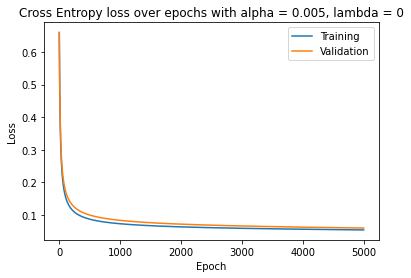

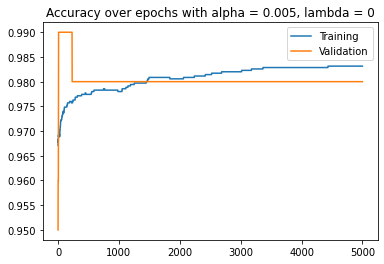

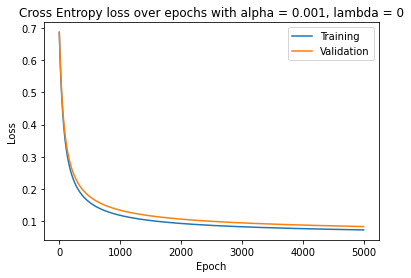

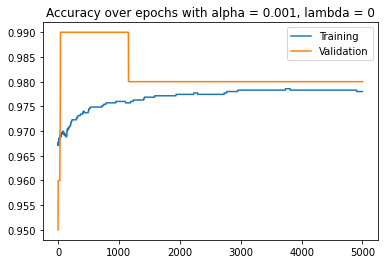

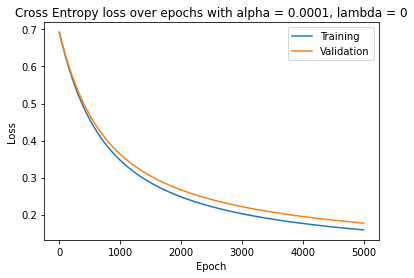

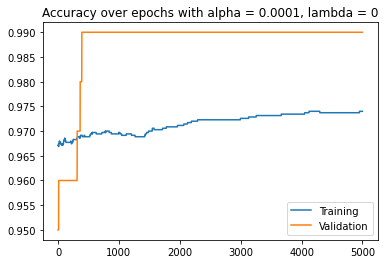

In [ ]:
learning_rates = [0.005, 0.001, 0.0001]
epochs = 5000
regularization = 0
W = np.zeros(28*28).reshape(28*28, 1)
b = 0

for alpha in learning_rates:
   grad_descent(W, b, trainData, trainTarget, alpha, epochs, regularization, 0, validData, validTarget)
  

#### Loss and  accuracy when $\lambda = 0$ and $\alpha = \{0.005, 0.001, 0.0001\}$
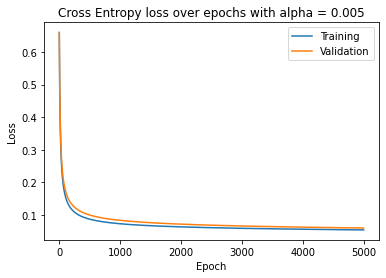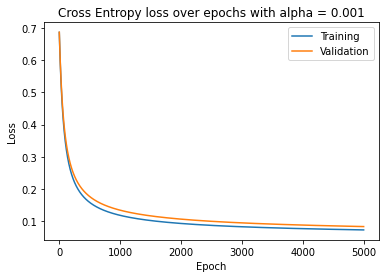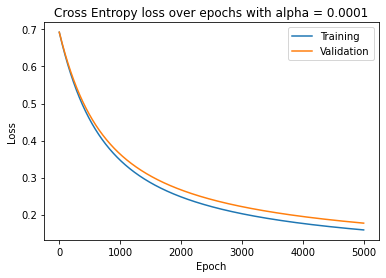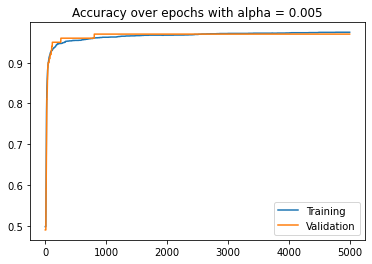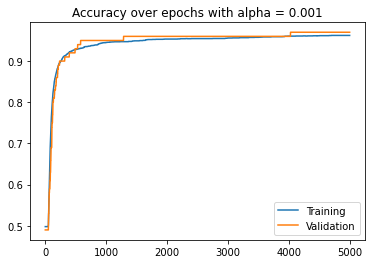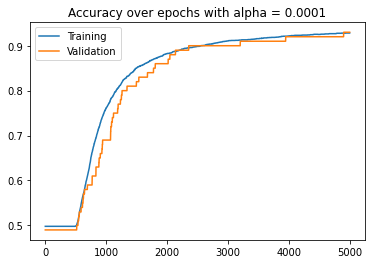


## Generalization:


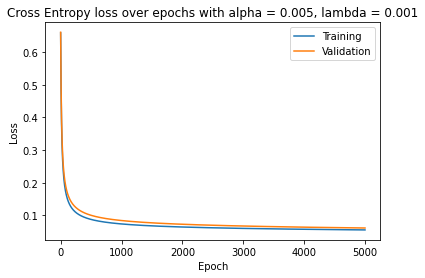

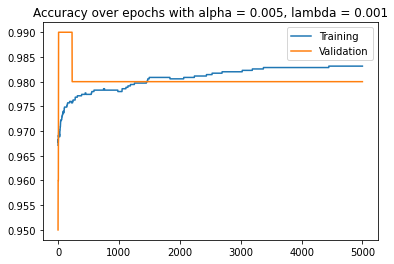

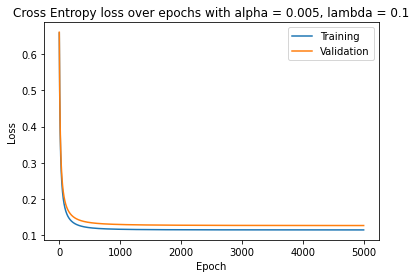

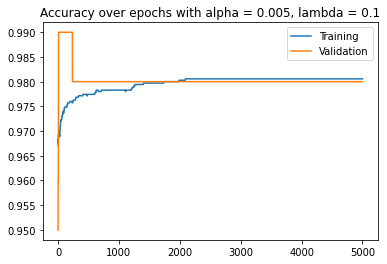

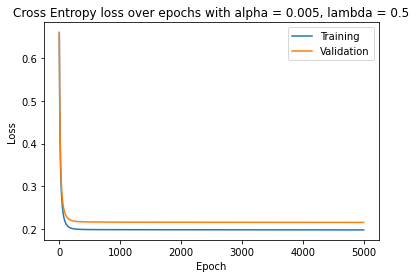

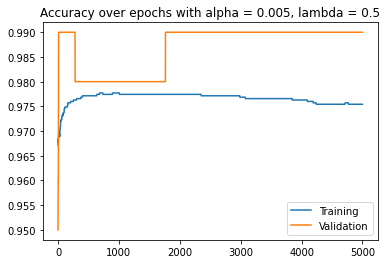

In [ ]:
alpha = 0.005
epochs = 5000
regularization = [0.001, 0.1, 0.5]
W = np.zeros(28*28).reshape(28*28, 1)
b = 0

for lmbda in regularization:
   grad_descent(W, b, trainData, trainTarget, alpha, epochs, lmbda, 0, validData, validTarget)

#### Loss and accuracy when $\lambda = \{0.001, 0.1, 0.5\}$ and $\alpha = 0.005$
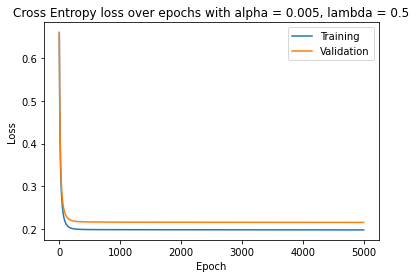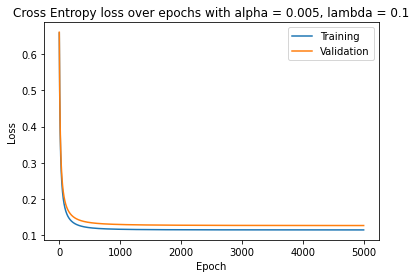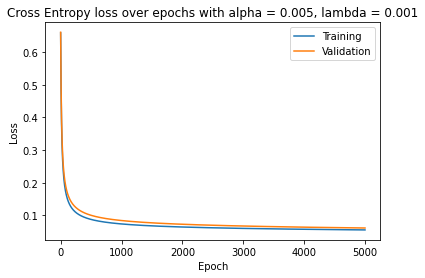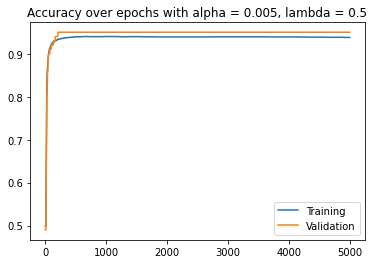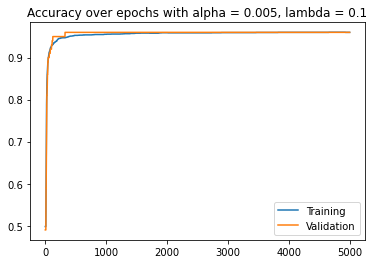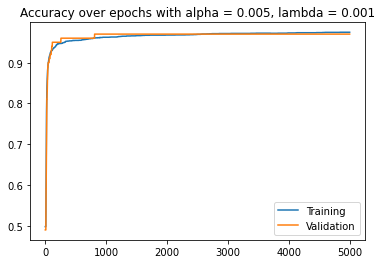

# Logistic Regression in TensorFlow

## Building the computational graph:


In [ ]:
def buildGraph(bias=0, reg=0, b1=0.9, b2=0.999, eps=1e-08):

  # Make the weight and bias TF variables
  W = tf.Variable(tf.truncated_normal(shape=(1, 784), stddev=0.5, dtype=tf.float32), name="weights", dtype=tf.float32)
  b = tf.Variable(bias, name="bias", dtype=tf.float32)

  # Data, labels, and lambda 
  data = tf.placeholder(tf.float32, (None, 784), name="data")
  labels = tf.placeholder(tf.float32, (None, 1), name="labels")
  lmbda = tf.constant(reg, tf.float32, name="lambda")

  valid_data = tf.placeholder(tf.float32, (None, 784), name="validdata")
  valid_label = tf.placeholder(tf.float32, (None, 1), name="validlabels")

  test_data = tf.placeholder(tf.float32, (None, 784), name="validdata")
  test_label = tf.placeholder(tf.float32, (None, 1), name="validlabels")

  # y_hat = XWT 
  y_hat = tf.matmul(data, tf.transpose(W)) + b

  # Regularization term 
  regularization = (lmbda / 2.0) * tf.matmul(W, tf.transpose(W))

  # Loss tensor: cross entropy loss of X and the regularization term.
  # Sigmoid corss entropy will return a vector so to make it a single element
  # add up all the elements using tf.reduce_sum
  ce_loss = tf.reduce_sum(tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=y_hat))
  ce_loss += regularization

  # Adam optimizer, and tell it to minimize our loss function
  optim = tf.train.AdamOptimizer(learning_rate=0.001, beta1=b1, beta2=b2, epsilon=eps)
  optim = optim.minimize(loss=ce_loss)

  # Also calculate the validation loss 
  valid_y_hat = tf.matmul(valid_data, tf.transpose(W)) + b
  valid_ce_loss = tf.reduce_sum(tf.losses.sigmoid_cross_entropy(multi_class_labels=valid_label, logits=valid_y_hat))
  valid_ce_loss += regularization

  test_y_hat = tf.matmul(test_data, tf.transpose(W)) + b
  test_ce_loss = tf.reduce_sum(tf.losses.sigmoid_cross_entropy(multi_class_labels=test_label, logits=test_y_hat))
  test_ce_loss += regularization

  return W, b, data, y_hat, labels, ce_loss, optim, regularization, valid_ce_loss, valid_data, valid_label, test_ce_loss, test_data, test_label


In [ ]:
buildGraph()

## Implementing stochastic gradient descent:


#### Stochastic gradient descent:
At each iteration uniformly randomly select the $n^{th}$ example from $\{1, 2, ... N\}$ and set $\vec{w_{k+1}} = \vec{w_k} - \gamma \nabla e_n(\vec{w_k})$ <br>
Two approaches to sampling: shift the entire data using tf.shuffle, or take a N random samples and arrange them to construct a new matix using np.permutation. I chose the former because of performace reasons. Both are completely valid.

In [ ]:
def train_model(X, Y, epochs, batch_size, learning_rate, bias=0, reg=0, b1=0.9, b2=0.999, eps=1e-08):
  tf.reset_default_graph()
  train_ERROR = []
  train_ACCURACY = []
  valid_ERROR = []
  valid_ACCURACY = []
  test_ERROR = []
  test_ACCURACY = []

  # Get the place holders, etc... for the weights, bias...
  W, b, data, y_hat, labels, ce_loss, optim, reg, valid_ce_loss, valid_data, valid_label, test_ce_loss, test_data, test_label = buildGraph(bias, reg, b1, b2, eps)
  
  # Create a node to initialize all varibles of the graph
  init_op = tf.global_variables_initializer()

  # Set a random uniform seed 
  tf.set_random_seed(1000)

  # Format the input data into a 1D vector, new shape should be:
  # (3500, 28, 28) -> (3500, 784)
  # So each row now corresponds to an image
  X_processed = tf.reshape(X, (X.shape[0], -1))
  processed_validData = tf.reshape(validData, (validData.shape[0], -1))
  processed_testData = tf.reshape(testData, (testData.shape[0], -1))

  with tf.Session() as sess:
    sess.run(init_op)
    print("Strating training...")
    print("Parameters (batch size, learning rate, samples) (", batch_size, learning_rate, X.shape[0], ")")
    data_shuffled = X_processed.eval(session=sess)
    label_shuffled = Y
    evaled_validL = validTarget
    evaled_validD = processed_validData.eval(session=sess)
    evaled_testL = testTarget
    evaled_testD = processed_testData.eval(session=sess)

    for itteration in range(epochs):

      # Total number of batches is number of instances over batch size
      total_batches = int(X.shape[0] / batch_size)

      # Generate 3500 random indices so that we can reconstruct X, and Y
      # in a random order, while still maintaing the X -> Y relation 
      random_indices = np.random.permutation(int(X.shape[0]))

      data_batch = data_shuffled[random_indices]
      label_batch = label_shuffled[random_indices]

      batch_step = 0

      for items in range(total_batches):
        
        # On each iteration get a sample of batch_size images and there associated
        # Label
        data_batch_np = data_batch[batch_step: (batch_step + batch_size) :]

        label_batch_np = label_batch[batch_step: (batch_step + batch_size) :]

        # Create a feed dictionary to give tensorflow varibles that will be fed 
        # into place holders...
        feed = {
          data : data_batch_np,
          labels : label_batch_np,
          valid_label : evaled_validL,
          valid_data :  evaled_validD,
          test_label : evaled_testL,
          test_data : evaled_testD
        }

        # Run the optimizer 
        ret_optim, ret_W, ret_b, ret_err, ret_yhat, ret_reg, ret_valid_ce_loss, ret_test_ce_loss = sess.run([optim, W, b, ce_loss, y_hat, reg, valid_ce_loss, test_ce_loss], feed_dict=feed)

        batch_step += batch_size
    
      # Calculate the loss and accuracy...
      # Use the returned predictions y_hat and compare them to the actual labels
      # Convert sign(ret_yhat) (which is either -1, 0, or 1) to 0 or 1
      predictions = tf.sign(tf.sign(ret_yhat) + 1)
      predictions = tf.cast(predictions, dtype=tf.dtypes.float32)

      results = tf.equal(predictions, tf.cast(label_batch_np, dtype=tf.dtypes.float32))
      results = tf.cast(results, dtype=tf.dtypes.float32)

      accuracy = tf.math.reduce_mean(results).eval(session=sess)
      error = ret_err[0][0]

      train_ERROR.append(error)
      train_ACCURACY.append(accuracy)

      # Use the returned bias and weights to make a prediction on the validation 
      # data, them calculate the error and the accuracy
      validation_predictions = tf.matmul(tf.cast(processed_validData, dtype=tf.dtypes.float32), tf.transpose(ret_W)) + ret_b
      validation_predictions = tf.sign(tf.sign(validation_predictions) + 1)

      validation_results = tf.equal(validation_predictions, tf.cast(validTarget, dtype=tf.dtypes.float32))
      validation_results = tf.cast(validation_results, dtype=tf.dtypes.float32)
      validation_results = tf.math.reduce_mean(validation_results).eval(session=sess)

      valid_ACCURACY.append(validation_results)
      valid_ERROR.append(ret_valid_ce_loss[0][0])

      testing_predictions = tf.matmul(tf.cast(processed_testData, dtype=tf.dtypes.float32), tf.transpose(ret_W)) + ret_b
      testing_predictions = tf.sign(tf.sign(testing_predictions) + 1)

      testing_results = tf.equal(testing_predictions, tf.cast(testTarget, dtype=tf.dtypes.float32))
      testing_results = tf.cast(testing_results, dtype=tf.dtypes.float32)
      testing_results = tf.math.reduce_mean(testing_results).eval(session=sess)

      test_ACCURACY.append(testing_results)
      test_ERROR.append(ret_test_ce_loss[0][0])

    return train_ERROR, train_ACCURACY, valid_ERROR, valid_ACCURACY, test_ERROR, test_ACCURACY    

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )


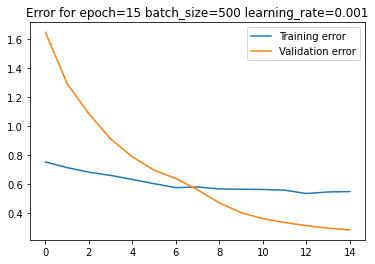

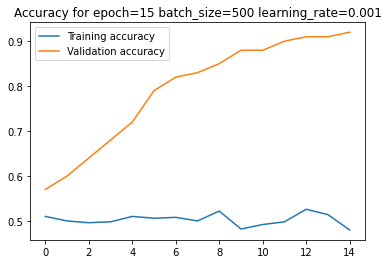

In [ ]:
# Minibatch size of 500, 700 epochs, learning rate 0.001
batch_size = 500
lr = 0.001
epcs = 15
train_error, train_accuracy, valid_error, valid_accuracy, testerr, testacc = train_model(trainData, trainTarget, epcs, batch_size, lr)

plt.plot(train_error, label="Training error")
plt.plot(valid_error, label="Validation error")
plt.title("Error for epoch=" + str(epcs) + " batch_size=" + str(batch_size)  + " learning_rate=" + str(lr))
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Training accuracy")
plt.plot(valid_accuracy, label="Validation accuracy")
plt.title("Accuracy for epoch=" + str(epcs) + " batch_size=" + str(batch_size)  + " learning_rate=" + str(lr))
plt.legend()
plt.show()


Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )


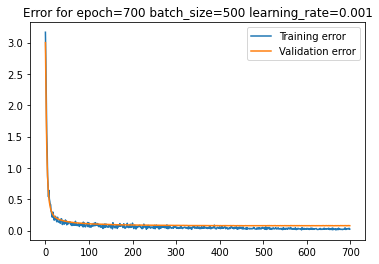

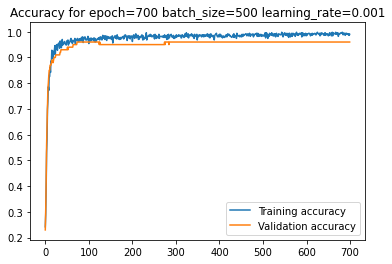

In [ ]:
# Minibatch size of 500, 700 epochs, learning rate 0.001
batch_size = 500
lr = 0.001
epcs = 700

train_error, train_accuracy, valid_error, valid_accuracy, testerr, testacc = train_model(trainData, trainTarget, epcs, batch_size, lr)

plt.plot(train_error, label="Training error")
plt.plot(valid_error, label="Validation error")
plt.title("Error for epoch=" + str(epcs) + " batch_size=" + str(batch_size)  + " learning_rate=" + str(lr))
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Training accuracy")
plt.plot(valid_accuracy, label="Validation accuracy")
plt.title("Accuracy for epoch=" + str(epcs) + " batch_size=" + str(batch_size)  + " learning_rate=" + str(lr))
plt.legend()
plt.show()


**Note:** The validation set only has 100 samples, so using a batch size of 500 doesn't work. To get around this I set the batch size for the validation set to be the number of samples it had.

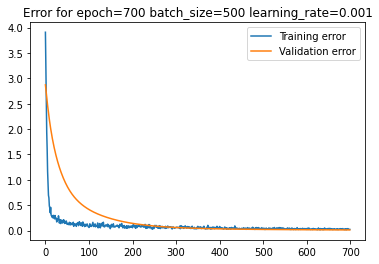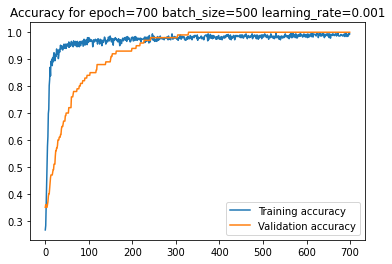

## Batch size investigation:


Strating training...
Parameters (batch size, learning rate, samples) ( 100 0.001 3500 )


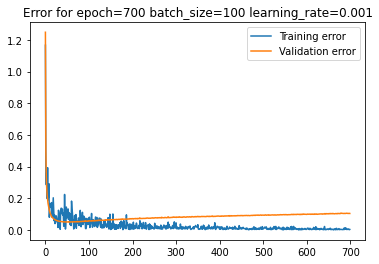

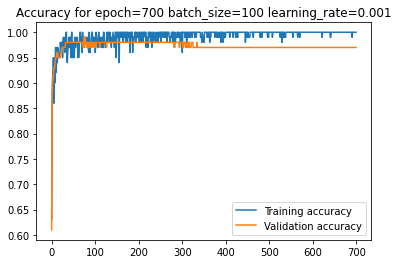

Strating training...
Parameters (batch size, learning rate, samples) ( 700 0.001 3500 )


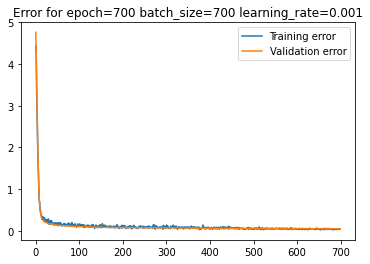

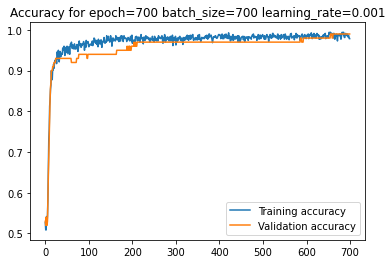

Strating training...
Parameters (batch size, learning rate, samples) ( 1750 0.001 3500 )


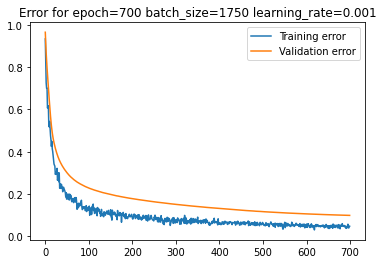

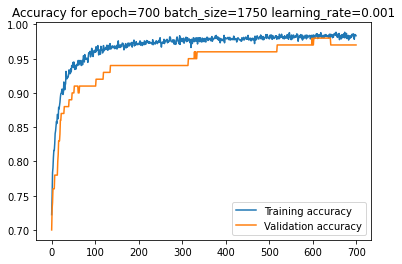

In [ ]:
batch_sizes = [100, 700, 1750]
epcs = 700
lr = 0.001

for batch in batch_sizes:
  train_error, train_accuracy, valid_error, valid_accuracy = train_model(trainData, trainTarget, epcs, batch, lr)

  plt.plot(train_error, label="Training error")
  plt.plot(valid_error, label="Validation error")
  plt.title("Error for epoch=" + str(epcs) + " batch_size=" + str(batch)  + " learning_rate=" + str(lr))
  plt.legend()
  plt.show()

  plt.plot(train_accuracy, label="Training accuracy")
  plt.plot(valid_accuracy, label="Validation accuracy")
  plt.title("Accuracy for epoch=" + str(epcs) + " batch_size=" + str(batch)  + " learning_rate=" + str(lr))
  plt.legend()
  plt.show()

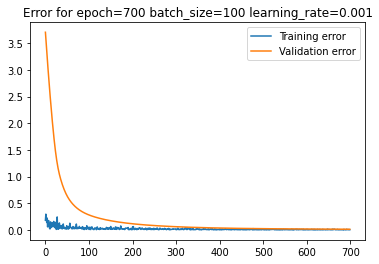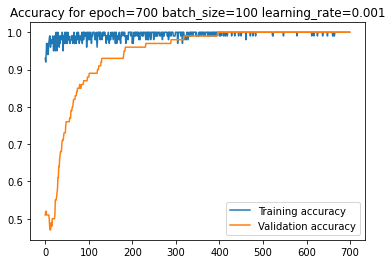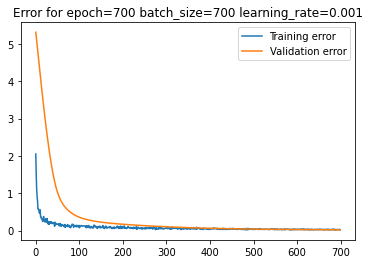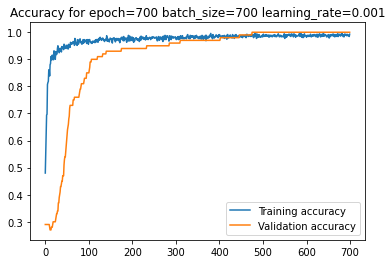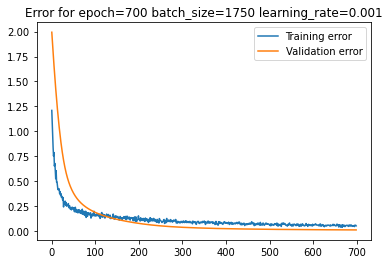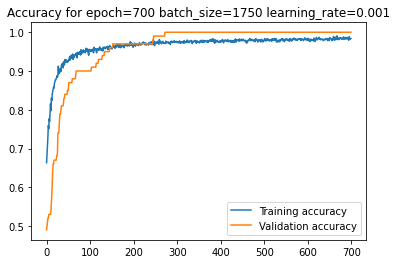

## Hyperparameter investigation:


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.5441996
Train Accuracy: 0.474
Validation Error : 0.13108684
Validation Accuracy: 0.94
Testing Error : 0.066976614
Testing Accuracy: 0.9724138


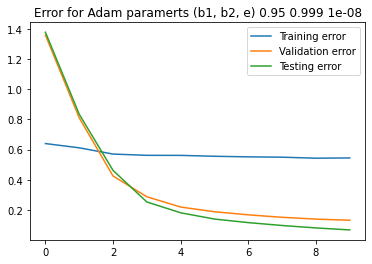

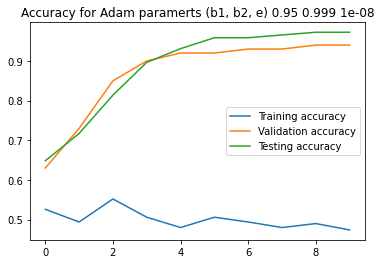

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.53820086
Train Accuracy: 0.484
Validation Error : 0.35020882
Validation Accuracy: 0.87
Testing Error : 0.18833724
Testing Accuracy: 0.9517241


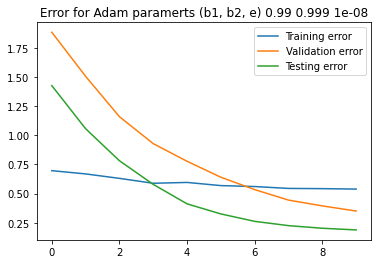

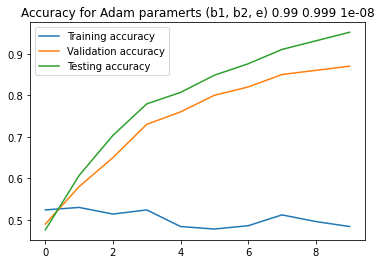

In [ ]:
batch = 500
lr = 0.001
epochs = 10
reg = 0.1

beta1 = [0.95, 0.99]
beta2 = [0.99, 0.9999]
epsilon = {1e-09, 1e-4}

for b_1 in beta1:
  b_2=0.999
  e_1=1e-08
  train_error, train_accuracy, valid_error, valid_accuracy, test_error, test_accuracy = train_model(trainData, trainTarget, epochs, batch, lr, bias=0, reg=0, b1=b_1, b2=b_2, eps=e_1)

  print("Train Error :", train_error[len(train_error) - 1])
  print("Train Accuracy:",  train_accuracy[len(train_accuracy) - 1])
  
  
  print("Validation Error :", valid_error[len(valid_error) - 1])
  print("Validation Accuracy:",  valid_accuracy[len(valid_accuracy) - 1])

  print("Testing Error :", test_error[len(test_error) - 1])
  print("Testing Accuracy:",  test_accuracy[len(test_accuracy) - 1])

  plt.plot(train_error, label="Training error")
  plt.plot(valid_error, label="Validation error")
  plt.plot(test_error, label="Testing error")
  plt.title("Error for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

  plt.plot(train_accuracy, label="Training accuracy")
  plt.plot(valid_accuracy, label="Validation accuracy")
  plt.plot(test_accuracy, label="Testing accuracy")
  plt.title("Accuracy for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.02862386
Train Accuracy: 0.992
Validation Error : 0.08200548
Validation Accuracy: 0.96
Testing Error : 0.15310086
Testing Accuracy: 0.97931033


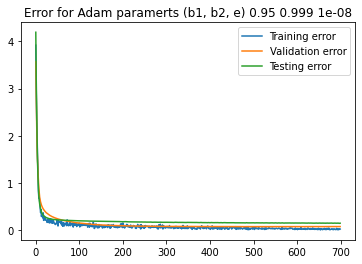

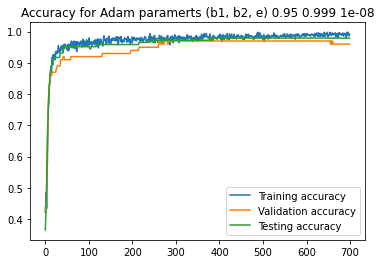

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.033744115
Train Accuracy: 0.982
Validation Error : 0.060813244
Validation Accuracy: 0.96
Testing Error : 0.1703294
Testing Accuracy: 0.9724138


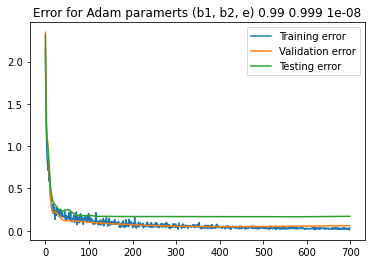

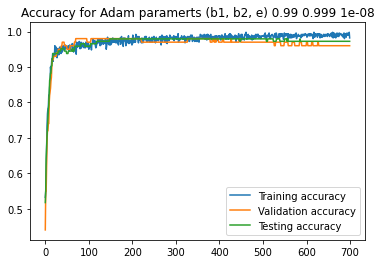

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.007823734
Train Accuracy: 1.0
Validation Error : 0.04994575
Validation Accuracy: 0.98
Testing Error : 0.19229428
Testing Accuracy: 0.97931033


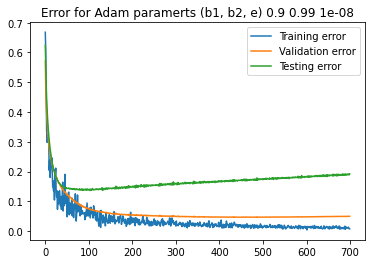

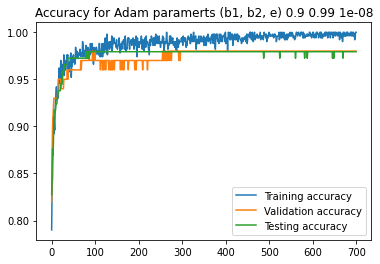

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.027370395
Train Accuracy: 0.992
Validation Error : 0.040367797
Validation Accuracy: 0.97
Testing Error : 0.13659653
Testing Accuracy: 0.9724138


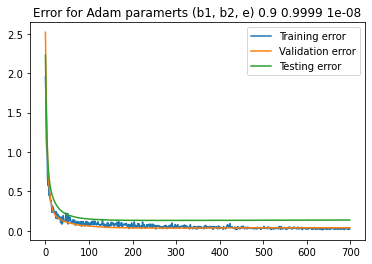

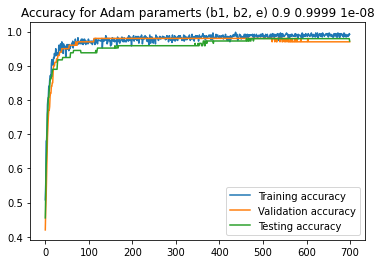

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.019013554
Train Accuracy: 0.994
Validation Error : 0.058172673
Validation Accuracy: 0.98
Testing Error : 0.14416355
Testing Accuracy: 0.97931033


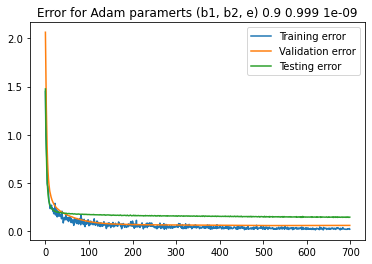

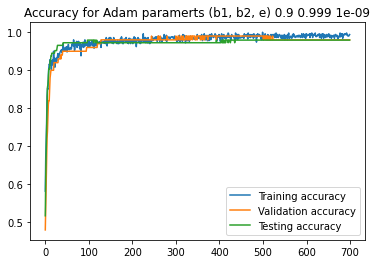

Strating training...
Parameters (batch size, learning rate, samples) ( 500 0.001 3500 )
Train Error : 0.024707748
Train Accuracy: 0.994
Validation Error : 0.035679027
Validation Accuracy: 0.98
Testing Error : 0.16751228
Testing Accuracy: 0.9724138


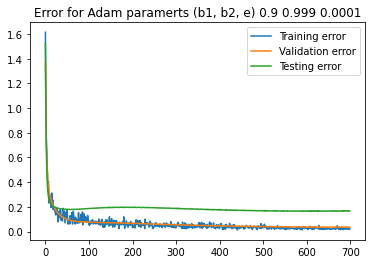

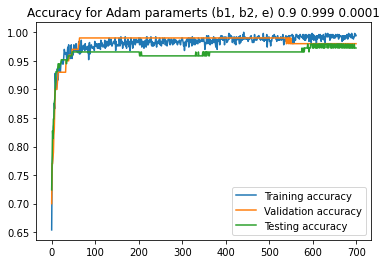

In [ ]:
batch = 500
lr = 0.001
epochs = 700
reg = 0.1

beta1 = [0.95, 0.99]
beta2 = [0.99, 0.9999]
epsilon = {1e-09, 1e-4}

for b_1 in beta1:
  b_2=0.999
  e_1=1e-08
  train_error, train_accuracy, valid_error, valid_accuracy, test_error, test_accuracy = train_model(trainData, trainTarget, epochs, batch, lr, bias=0, reg=0, b1=b_1, b2=b_2, eps=e_1)

  print("Train Error :", train_error[len(train_error) - 1])
  print("Train Accuracy:",  train_accuracy[len(train_accuracy) - 1])
  
  
  print("Validation Error :", valid_error[len(valid_error) - 1])
  print("Validation Accuracy:",  valid_accuracy[len(valid_accuracy) - 1])

  print("Testing Error :", test_error[len(test_error) - 1])
  print("Testing Accuracy:",  test_accuracy[len(test_accuracy) - 1])

  plt.plot(train_error, label="Training error")
  plt.plot(valid_error, label="Validation error")
  plt.plot(test_error, label="Testing error")
  plt.title("Error for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

  plt.plot(train_accuracy, label="Training accuracy")
  plt.plot(valid_accuracy, label="Validation accuracy")
  plt.plot(test_accuracy, label="Testing accuracy")
  plt.title("Accuracy for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

for b_2 in beta2:
  b_1=0.9
  e_1=1e-08
  train_error, train_accuracy, valid_error, valid_accuracy, test_error, test_accuracy = train_model(trainData, trainTarget, epochs, batch, lr, bias=0, reg=0, b1=b_1, b2=b_2, eps=e_1)

  print("Train Error :", train_error[len(train_error) - 1])
  print("Train Accuracy:",  train_accuracy[len(train_accuracy) - 1])
  
  print("Validation Error :", valid_error[len(valid_error) - 1])
  print("Validation Accuracy:",  valid_accuracy[len(valid_accuracy) - 1])

  print("Testing Error :", test_error[len(test_error) - 1])
  print("Testing Accuracy:",  test_accuracy[len(test_accuracy) - 1])


  plt.plot(train_error, label="Training error")
  plt.plot(valid_error, label="Validation error")
  plt.plot(test_error, label="Testing error")
  plt.title("Error for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

  plt.plot(train_accuracy, label="Training accuracy")
  plt.plot(valid_accuracy, label="Validation accuracy")
  plt.plot(test_accuracy, label="Testing accuracy")
  plt.title("Accuracy for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

for e_1 in epsilon:
  b_1=0.9
  b_2=0.999
  train_error, train_accuracy, valid_error, valid_accuracy, test_error, test_accuracy = train_model(trainData, trainTarget, epochs, batch, lr, bias=0, reg=0, b1=b_1, b2=b_2, eps=e_1)

  print("Train Error :", train_error[len(train_error) - 1])
  print("Train Accuracy:",  train_accuracy[len(train_accuracy) - 1])
  
  print("Validation Error :", valid_error[len(valid_error) - 1])
  print("Validation Accuracy:",  valid_accuracy[len(valid_accuracy) - 1])

  print("Testing Error :", test_error[len(test_error) - 1])
  print("Testing Accuracy:",  test_accuracy[len(test_accuracy) - 1])

  plt.plot(train_error, label="Training error")
  plt.plot(valid_error, label="Validation error")
  plt.plot(test_error, label="Testing error")
  plt.title("Error for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()

  plt.plot(train_accuracy, label="Training accuracy")
  plt.plot(valid_accuracy, label="Validation accuracy")
  plt.plot(test_accuracy, label="Testing accuracy")
  plt.title("Accuracy for Adam paramerts (b1, b2, e) "  + str(b_1) + " " + str(b_2) + " " + str(e_1))
  plt.legend()
  plt.show()
